Import Packages

In [2]:
import math
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torchvision



from transformers import set_seed
from pixel import (
    PIXELConfig,
    PIXELForPreTraining,
    BartForConditionalGeneration,
    SpanMaskingGenerator,
    PyGameTextRenderer,
    get_transforms,
    resize_model_embeddings,
    truncate_decoder_pos_embeddings,
    get_attention_mask
)

/work/sc118/sc118/xliao11/miniconda3/envs/pixel-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def clip(x: torch.Tensor):
    x = torch.einsum("chw->hwc", x)
    x = torch.clip(x * 255, 0, 255)
    x = torch.einsum("hwc->chw", x)
    return x

def get_image(img: torch.Tensor, do_clip: bool = True):
    if do_clip:
        img = clip(img)
    img = torchvision.utils.make_grid(img, normalize=True)
    image = Image.fromarray(
        img.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    )
    return image

def unpatchify(imgs):
    return square imgs

def inference(text: str, mask_ratio: float = 0.25, max_span_length: int = 6, seed: int = 42):
    config.update({"mask_ratio": mask_ratio})
    resize_model_embeddings(model, max_seq_length)
    truncate_decoder_pos_embeddings(model, max_seq_length)

    set_seed(seed)

    transforms = get_transforms(
        do_resize=True,
        size=(text_renderer.pixels_per_patch, text_renderer.pixels_per_patch * text_renderer.max_seq_length),
    )

    encoding = text_renderer(text=text)
    attention_mask = get_attention_mask(
        num_text_patches=encoding.num_text_patches, seq_length=text_renderer.max_seq_length
    )

    img = transforms(Image.fromarray(encoding.pixel_values)).unsqueeze(0)
    attention_mask = attention_mask.unsqueeze(0)
    inputs = {"pixel_values": img.float(), "attention_mask": attention_mask}

    mask_generator = SpanMaskingGenerator(
        num_patches=text_renderer.max_seq_length,
        num_masking_patches=math.ceil(mask_ratio * text_renderer.max_seq_length),
        max_span_length=max_span_length,
        spacing="span"
    )
    mask = torch.tensor(mask_generator(num_text_patches=(encoding.num_text_patches + 1))).unsqueeze(0)
    inputs.update({"patch_mask": mask})

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    predictions = model.unpatchify(outputs["logits"]).detach().cpu().squeeze()
    print(predictions.shape)

    mask = outputs["mask"].detach().cpu()
    mask = mask.unsqueeze(-1).repeat(1, 1, text_renderer.pixels_per_patch ** 2 * 3)
    mask = model.unpatchify(mask).squeeze()  # 1 is removing, 0 is keeping

    attention_mask = attention_mask.unsqueeze(-1).repeat(1, 1, text_renderer.pixels_per_patch ** 2 * 3)
    attention_mask = model.unpatchify(attention_mask).squeeze()

    original_img = model.unpatchify(model.patchify(img)).squeeze()

    im_masked = original_img * (1 - (torch.bitwise_and(mask == 1, attention_mask == 1)).long())

    masked_predictions = predictions * mask * attention_mask

    reconstruction = im_masked + masked_predictions

    return [get_image(original_img), get_image(im_masked), get_image(masked_predictions, do_clip=False), get_image(reconstruction, do_clip=False)]

SyntaxError: invalid syntax (2528319199.py, line 17)

In [4]:
### train projection only for 10000 steps

In [118]:
x=[["JFK","SFO","ATL","JFK","ATL","SFO"], ["JFK","ATL","JFK","SFO","ATL","SFO"]]
x[0]

TypeError: 'NoneType' object is not subscriptable

In [125]:
nums = [-1]
results = 0 - min([abs(num) for num in nums])
results

-1

### train projection only for 10000 steps

In [106]:
model_name_or_path = "../../experiment/train_projection/4526922/outputs/"
max_seq_length = 529
text = "Penguins are designed to be streamlined and hydrodynamic, so having long legs would add extra drag. Having short legs with webbed feet to act like rudders, helps to give them that torpedo-like figure. If we compare bird anatomy with humans, we would see something a bit peculiar. By taking a look at the side-by-side image in Figure 1, you can see how their leg bones compare to ours. What most people mistake for knees are actually the ankles of the birds. This gives the illusion that bird knees bend opposite of ours. The knees are actually tucked up inside the body cavity of the bird! So how does this look inside of a penguin? In the images below, you can see boxes surrounding the penguins’ knees."
text_renderer = PyGameTextRenderer.from_pretrained(model_name_or_path, max_seq_length=max_seq_length)
config = PIXELConfig.from_pretrained(model_name_or_path)
model = PIXELForPreTraining.from_pretrained(model_name_or_path, config=config)

In [107]:
original, masked, prediction, mae = inference(text, 0.2, 6, 42)

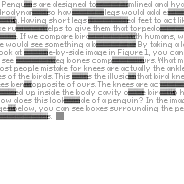

In [108]:
mae

### train projection and model for 10000 steps

In [5]:
model_name_or_path = "../../experiment/train_projection/4526921/outputs/"
max_seq_length = 529
text = "Penguins are designed to be streamlined and hydrodynamic, so having long legs would add extra drag. Having short legs with webbed feet to act like rudders, helps to give them that torpedo-like figure. If we compare bird anatomy with humans, we would see something a bit peculiar. By taking a look at the side-by-side image in Figure 1, you can see how their leg bones compare to ours. What most people mistake for knees are actually the ankles of the birds. This gives the illusion that bird knees bend opposite of ours. The knees are actually tucked up inside the body cavity of the bird! So how does this look inside of a penguin? In the images below, you can see boxes surrounding the penguins’ knees."
text_renderer = PyGameTextRenderer.from_pretrained(model_name_or_path, max_seq_length=max_seq_length)
config = PIXELConfig.from_pretrained(model_name_or_path)
model = PIXELForPreTraining.from_pretrained(model_name_or_path, config=config)

In [6]:
original, masked, prediction, mae = inference(text, 0.2, 6, 42)

torch.Size([3, 8, 4232])


In [7]:
mae

### pixel-base after pretraining 1000 steps

In [100]:
model_name_or_path = "../../cache/models/pixel-base"
max_seq_length = 529
text = "Penguins are designed to be streamlined and hydrodynamic, so having long legs would add extra drag. Having short legs with webbed feet to act like rudders, helps to give them that torpedo-like figure. If we compare bird anatomy with humans, we would see something a bit peculiar. By taking a look at the side-by-side image in Figure 1, you can see how their leg bones compare to ours. What most people mistake for knees are actually the ankles of the birds. This gives the illusion that bird knees bend opposite of ours. The knees are actually tucked up inside the body cavity of the bird! So how does this look inside of a penguin? In the images below, you can see boxes surrounding the penguins’ knees."
text_renderer = PyGameTextRenderer.from_pretrained(model_name_or_path, max_seq_length=max_seq_length)
config = PIXELConfig.from_pretrained(model_name_or_path)
model = PIXELForPreTraining.from_pretrained(model_name_or_path, config=config)

In [101]:
original, masked, prediction, mae = inference(text, 0.2, 6, 42)

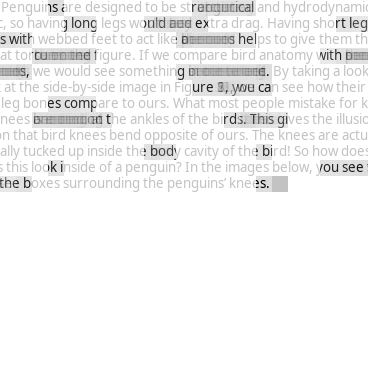

In [102]:
mae

### pixel-base downloaded

In [8]:
model_name_or_path = "../../cache/models/pixel-base"
max_seq_length = 529
text = "Penguins are designed to be streamlined and hydrodynamic, so having long legs would add extra drag. Having short legs with webbed feet to act like rudders, helps to give them that torpedo-like figure. If we compare bird anatomy with humans, we would see something a bit peculiar. By taking a look at the side-by-side image in Figure 1, you can see how their leg bones compare to ours. What most people mistake for knees are actually the ankles of the birds. This gives the illusion that bird knees bend opposite of ours. The knees are actually tucked up inside the body cavity of the bird! So how does this look inside of a penguin? In the images below, you can see boxes surrounding the penguins’ knees."
text_renderer = PyGameTextRenderer.from_pretrained(model_name_or_path, max_seq_length=max_seq_length)
config = PIXELConfig.from_pretrained(model_name_or_path)
model = PIXELForPreTraining.from_pretrained(model_name_or_path, config=config)

In [9]:
original, masked, prediction, mae = inference(text, 0.2, 6, 42)

torch.Size([3, 16, 8464])


In [10]:
mae

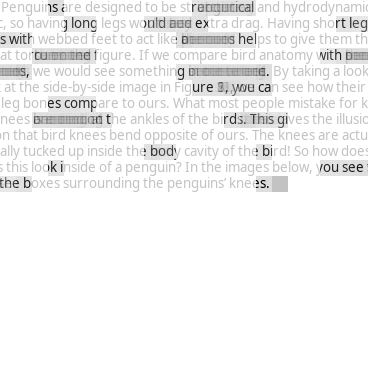

In [99]:
mae

### Team-PIXEL/pixel-base

In [80]:
model_name_or_path = "Team-PIXEL/pixel-base"
max_seq_length = 529
text = "Penguins are designed to be streamlined and hydrodynamic, so having long legs would add extra drag. Having short legs with webbed feet to act like rudders, helps to give them that torpedo-like figure. If we compare bird anatomy with humans, we would see something a bit peculiar. By taking a look at the side-by-side image in Figure 1, you can see how their leg bones compare to ours. What most people mistake for knees are actually the ankles of the birds. This gives the illusion that bird knees bend opposite of ours. The knees are actually tucked up inside the body cavity of the bird! So how does this look inside of a penguin? In the images below, you can see boxes surrounding the penguins’ knees."

In [81]:
original, masked, prediction, mae = inference(text, 0.2, 6, 42)

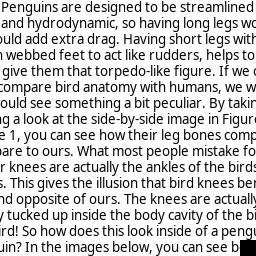

In [82]:
original

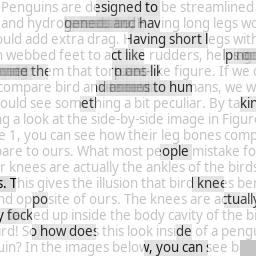

In [85]:
mae

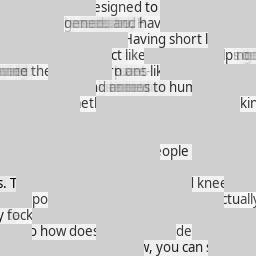

In [84]:
prediction

In [61]:
args={
    "input_str": "Cats conserve energy by sleeping more than most animals, especially as they grow older.",
    "model_name_or_path": "../../experiment/train_projection/4526921/outputs" ,
    "span_mask": True,
    "mask_ratio": 0.25,
    "max_seq_length": 256,
    "seed": 42,
    "masking_max_span_length": 6,
    "masking_cumulative_span_weights": "0.2,0.4,0.6,0.8,0.9,1",
}


if args['masking_cumulative_span_weights']:
    args['masking_cumulative_span_weights'] = [
        float(w) for w in args['masking_cumulative_span_weights'].replace(" ", "").split(",")
    ]

Running PIXEL masked autoencoding with pixel reconstruction


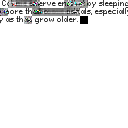

In [62]:
main(args)

 pixel-base after pretraining 1000 steps

In [74]:
args={
    "input_str": "In many, many ways, fish of the species Brienomyrus brachyistius do not speak at all like Barack Obama. For starters, they communicate not through a spoken language but through electrical pulses booped out by specialized organs found near the tail. ",
    "model_name_or_path": "../../experiment/4446073/outputs" ,
    "span_mask": True,
    "mask_ratio": 0.25,
    "max_seq_length": 256,
    "seed": 42,
    "masking_max_span_length": 6,
    "masking_cumulative_span_weights": "0.2,0.4,0.6,0.8,0.9,1",
}


if args['masking_cumulative_span_weights']:
    args['masking_cumulative_span_weights'] = [
        float(w) for w in args['masking_cumulative_span_weights'].replace(" ", "").split(",")
    ]

Running PIXEL masked autoencoding with pixel reconstruction


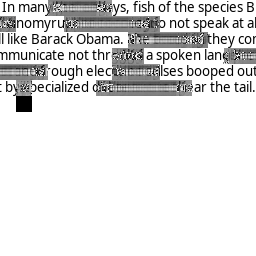

In [75]:
main(args)

 pixel-base

In [68]:
args={
    "input_str": "Cats conserve energy by sleeping more than most animals, especially as they grow older.",
    "model_name_or_path": "../../cache/models/pixel-base" ,
    "span_mask": True,
    "mask_ratio": 0.5,
    "max_seq_length": 256,
    "seed": 42,
    "masking_max_span_length": 1,
    #"masking_cumulative_span_weights": "0.2,0.4,0.6,0.8,0.9,1",
}

'''
if args['masking_cumulative_span_weights']:
    args['masking_cumulative_span_weights'] = [
        float(w) for w in args['masking_cumulative_span_weights'].replace(" ", "").split(",")
    ]
'''


'\nif args[\'masking_cumulative_span_weights\']:\n    args[\'masking_cumulative_span_weights\'] = [\n        float(w) for w in args[\'masking_cumulative_span_weights\'].replace(" ", "").split(",")\n    ]\n'

Running PIXEL masked autoencoding with pixel reconstruction


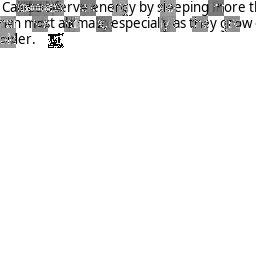

In [69]:
main(args)

In [66]:
def main(args):
    set_seed(args["seed"])

    #wandb.init()
    #wandb.run.name = args.revision


    config_kwargs = {
        "use_auth_token":  None,
        "revision": None,
    }


    # Load renderer
    text_renderer = PyGameTextRenderer.from_pretrained(
        args["model_name_or_path"],
        max_seq_length=args["max_seq_length"],
        **config_kwargs,
    )

    # Load model
    config = AutoConfig.from_pretrained(args["model_name_or_path"], **config_kwargs)

    #mask_ratio = args["mask_ratio"] if not args["manual_mask"] else len(args["manual_mask"]) / text_renderer.max_seq_length
    mask_ratio = args["mask_ratio"]
    config.update({"mask_ratio": mask_ratio})

    model = PIXELForPreTraining.from_pretrained(args["model_name_or_path"], config=config, **config_kwargs)

    # Resize position embeddings in case we use shorter sequence lengths
    resize_model_embeddings(model, text_renderer.max_seq_length)
    truncate_decoder_pos_embeddings(model, text_renderer.max_seq_length)

    print("Running PIXEL masked autoencoding with pixel reconstruction")

    # Get transformations
    transforms = get_transforms(
        do_resize=True,
        size=(text_renderer.pixels_per_patch, text_renderer.pixels_per_patch * text_renderer.max_seq_length),
    )

    # Render input
    encoding = text_renderer(text=args["input_str"])
    attention_mask = get_attention_mask(
        num_text_patches=encoding.num_text_patches, seq_length=text_renderer.max_seq_length
    )

    img = transforms(Image.fromarray(encoding.pixel_values)).unsqueeze(0)
    attention_mask = attention_mask.unsqueeze(0)
    inputs = {"pixel_values": img.float(), "attention_mask": attention_mask}

    # Generate the mask
    '''
    if args["manual_mask"]:
        logger.info("Using manual masking")
        mask = torch.zeros(size=(1, text_renderer.max_seq_length))
        for idx in args["manual_mask"]:
            mask[0][idx] = 1
    '''
    if args["span_mask"]:
        mask_generator = SpanMaskingGenerator(
            num_patches=text_renderer.max_seq_length,
            num_masking_patches=math.ceil(mask_ratio * text_renderer.max_seq_length),
            max_span_length=args["masking_max_span_length"],
            #spacing=args["masking_spacing"] if args["masking_spacing"] else "span",
            spacing= "span",
            #cumulative_span_weights=args["masking_cumulative_span_weights"],
            #cumulative_span_weights=None
        )
        mask = torch.tensor(mask_generator(num_text_patches=(encoding.num_text_patches + 1))).unsqueeze(0)
    else:
        logger.info("Using random masking")
        mask = None

    if mask is not None:
        masked_count = torch.count_nonzero(mask != 0, dim=1)[0]
        logger.info(f"Masked count: {masked_count}, ratio = {(masked_count / text_renderer.max_seq_length):0.4f}")
        inputs.update({"patch_mask": mask})
    else:
        logger.info(f"Masked count: {math.ceil(mask_ratio * text_renderer.max_seq_length)}, ratio = {mask_ratio:0.2f}")

    # Run MAE
    model.eval()
    with torch.inference_mode():
        outputs = model(**inputs)

    predictions = model.unpatchify(outputs["logits"]).detach().cpu().squeeze()

    # Log mask
    mask = outputs["mask"].detach().cpu()
    mask = mask.unsqueeze(-1).repeat(1, 1, text_renderer.pixels_per_patch ** 2 * 3)
    mask = model.unpatchify(mask).squeeze()  # 1 is removing, 0 is keeping

    # Log attention mask
    attention_mask = attention_mask.unsqueeze(-1).repeat(1, 1, text_renderer.pixels_per_patch ** 2 * 3)
    attention_mask = model.unpatchify(attention_mask).squeeze()

    # original image
    original_img = model.unpatchify(model.patchify(img)).squeeze()
    
    
    # log masked image
    im_masked = original_img * (1 - mask)

    # Log masked predictions
    masked_predictions = predictions * mask * attention_mask

    # Log MAE reconstruction pasted with visible patches
    reconstruction = (
        original_img * (1 - (torch.bitwise_and(mask == 1, attention_mask == 1)).long())
        + predictions * mask * attention_mask
    )
    return T.ToPILImage()(reconstruction)

In [1]:
from datasets import interleave_datasets, load_dataset, load_from_disk


In [3]:
dataset = load_dataset("bookcorpus")

Generating train split:   0%|          | 0/74004228 [00:00<?, ? examples/s]

In [4]:
dataset.save_to_disk('../../storage/enwiki storage/bookcorpus')

Saving the dataset (0/10 shards):   0%|          | 0/74004228 [00:00<?, ? examples/s]

In [5]:
label_list = raw_dataset["train"].features["label"].names
num_labels = len(label_list)

In [6]:
num_labels

3

In [4]:
ds = load_from_disk('../../cache/datasets/glue/sst2')

In [2]:
train_dataset = load_from_disk("../../cache/datasets/rendered_bookcorpus_8x8")
train_book,valid_book = train_dataset.train_test_split(test_size=0.0001).values()
train_dataset = load_from_disk('../../cache/datasets/rendered_wikipedia_8x8')
train_wiki,valid_wiki = train_dataset.train_test_split(test_size=0.0001).values()

In [3]:
len(train_book), len(valid_book),len(train_wiki), len(valid_wiki)

(6699330, 670, 23497650, 2350)

In [4]:
valid_datasets = [valid_book, valid_wiki]
dataset_sizes = [len(ds) for ds in valid_datasets]
combined_size = sum(dataset_sizes)
dataset_sampling_probs = [d_size / combined_size for d_size in dataset_sizes]
valid_dataset = interleave_datasets(valid_datasets, probabilities=dataset_sampling_probs, seed=42)


In [5]:
dataset_sizes

[670, 2350]

In [6]:
len(valid_dataset)

2951

In [7]:
valid_dataset.save_to_disk("../../cache/datasets/interleave_8x8_eval")

In [9]:
train_book.save_to_disk("../../cache/datasets/interleave_8x8_train/book")

Saving the dataset (0/69 shards):   0%|          | 1000/6699330 [00:51<65:41:23, 28.32 examples/s]

KeyboardInterrupt: 

In [ ]:
train_book.save_to_disk("../../cache/datasets/interleave_8x8_train/book")

In [11]:
train_datasets = [train_book, train_wiki]
dataset_sizes = [len(ds) for ds in train_datasets]
combined_size = sum(dataset_sizes)
dataset_sampling_probs = [d_size / combined_size for d_size in dataset_sizes]
train_dataset = interleave_datasets(train_datasets, probabilities=dataset_sampling_probs, seed=42)

KeyboardInterrupt: 